In [1]:
%load_ext autoreload

In [19]:
%autoreload

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jacket.modelling import hmc
from jacket.optim.optimizers import sgd
from jacket.utils import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

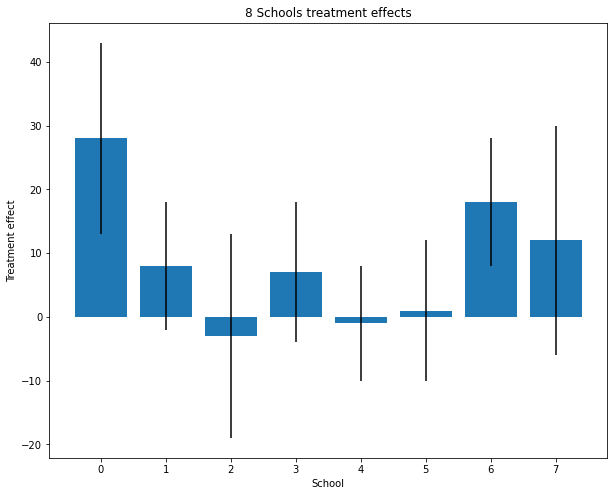

In [3]:
num_schools = 8  # number of schools
treatment_effects = jnp.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=jnp.float32)  # treatment effects
treatment_stddevs = jnp.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=jnp.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [4]:
@jax.jit
def ln_posterior(params, data):
    target = 0.
    target += stats.norm.logpdf(params['mu'], 0., 10.)
    target += stats.norm.logpdf(params['logtau'], 5., 1.)
    target += stats.norm.logpdf(params['theta_prime']).sum()
    theta_i = params['mu'] + jnp.exp(params['logtau']) * params['theta_prime']
    target += stats.norm.logpdf(data['treatment_effect'], loc=theta_i, scale=data['treatment_std']).sum()
    return target.sum()

In [5]:
params = dict(
    mu=jnp.zeros(1),
    logtau=jnp.zeros(1),
    theta_prime=jnp.zeros(8),
)

data = dict(
    treatment_effect=treatment_effects,
    treatment_std=treatment_stddevs,
)

In [6]:
params = sgd(ln_posterior, params, 1e-5, 1000, data=data)

In [42]:
samples, momentum = hmc.sample(ln_posterior, params, step_size=0.2, leapfrog_steps=5, data=data)

100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 899.67it/s]


In [45]:
school_effect_samples = samples['mu'] + jnp.exp(samples['logtau']) * samples['theta_prime']

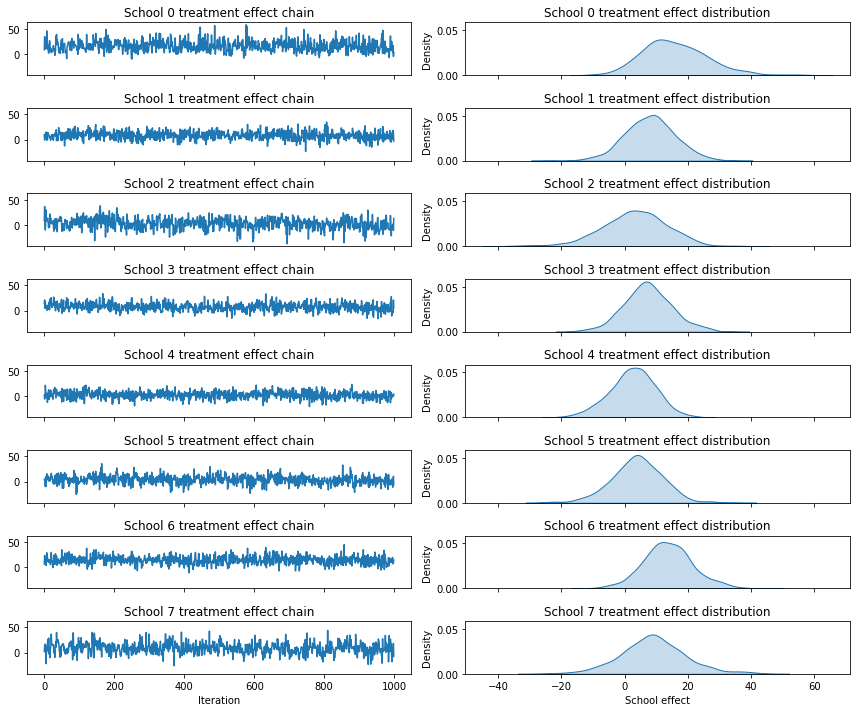

In [46]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effect_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effect_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()